## **Importing libraries and datasets**

 - Compare many model Logistic/Xg-Boots/TF
 - 

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
import xgboost as xgb

from sklearn.metrics import precision_score, recall_score, f1_score, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix, roc_curve
from xgboost import plot_importance


# Import data

In [3]:
#Import data
file = "1iCvmvHMssbWjH0SZaVLBjblWSaonN6jV"
dwn_url=f"https://drive.google.com/uc?export=download&id={file}"
df_response = pd.read_csv(dwn_url)
print(f"size of dataframe : {df_response.shape}")
df_response.head(3)

size of dataframe : (6884, 2)


,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1


In [4]:
file = "1rxbvbaXAiWEH_99X1gx1q5xts9MtN4VT"
dwn_url=f"https://drive.google.com/uc?export=download&id={file}"
df_transactions = pd.read_csv(dwn_url , parse_dates=['trans_date'])
print(f"size of dataframe : {df_transactions.shape}")
df_transactions.head(3)

size of dataframe : (125000, 3)


,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52


In [5]:
print(df_transactions['trans_date'].min())
print(df_transactions['trans_date'].max())

2011-05-16 00:00:00
2015-03-16 00:00:00


# Data Preparation

In [6]:
## since the last date of the data is 16 March 2015, the campaign date is assumed to be 17 March 2015
## RFM model will be used to predict campaign response. Recency is calculated
campaign_date = dt.datetime(2015,3,17)
df_transactions['recent']= campaign_date - df_transactions['trans_date']
df_transactions['recent'].astype('timedelta64[D]')
df_transactions['recent']=df_transactions['recent'] / np.timedelta64(1, 'D')
df_transactions.head(3)

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0


In [7]:
df_feature = df_transactions.groupby('customer_id').agg(
        ## create data set with RFM variables
          recency=('recent',min)
         ,frequency=('trans_date',pd.Series.nunique)
        ,monetary_value = ('tran_amount' ,sum)
        ## create data set with CLV variables
        ,ticket_size = ('tran_amount' ,np.mean)
        ,AOU = ('trans_date' ,lambda x: (x.max() - x.min()).days)
        ,spend_var = ('tran_amount' ,np.std)
        ,spend_p50 = ('tran_amount' ,np.median)
        )
       
df_feature.head(3)

,recency,frequency,monetary_value,ticket_size,AOU,spend_var,spend_p50
customer_id,,,,,,,
CS1112,62.0,15,1012,67.466667,1309,19.766012,63.0
CS1113,36.0,19,1490,74.500000,1354,21.254102,79.5
CS1114,33.0,19,1432,75.368421,1309,21.341692,79.0


In [8]:
df_3M = df_transactions[df_transactions['trans_date'] > '2014-12-17'].groupby('customer_id').agg(
        ## create data set with RFM variables
          recency_3m=('recent',min)
         ,frequency_3m=('trans_date',pd.Series.nunique)
         ,monetary_value_3m = ('tran_amount' ,sum)
        ## create data set with CLV variables
        ,ticket_size_3m = ('tran_amount' ,np.mean)
        ,AOU_3m = ('trans_date' ,lambda x: (x.max() - x.min()).days)
        ,spend_var_3m = ('tran_amount' ,np.std)
        ,spend_p50_3m = ('tran_amount' ,np.median)
        )
       
df_3M.head(3)

,recency_3m,frequency_3m,monetary_value_3m,ticket_size_3m,AOU_3m,spend_var_3m,spend_p50_3m
customer_id,,,,,,,
CS1112,62.0,1,39,39.000000,0,NaN,39.0
CS1113,36.0,2,220,73.333333,26,27.300794,78.0
CS1114,33.0,2,174,87.000000,43,11.313708,87.0


# Mapping Data

In [11]:
df_response = df_response.set_index('customer_id')
df_response.head(2)

,response
customer_id,
CS1112,0
CS1113,0


In [12]:
## merging two data sets - RFM
df_modeling = pd.merge(df_response,df_feature ,how='inner' ,on='customer_id').join(df_3M).fillna(0)
df_modeling.head()

,response,recency,frequency,monetary_value,ticket_size,AOU,spend_var,spend_p50,recency_3m,frequency_3m,monetary_value_3m,ticket_size_3m,AOU_3m,spend_var_3m,spend_p50_3m
customer_id,,,,,,,,,,,,,,,
CS1112,0,62.0,15,1012,67.466667,1309,19.766012,63.0,62.0,1.0,39.0,39.000000,0.0,0.000000,39.0
CS1113,0,36.0,19,1490,74.500000,1354,21.254102,79.5,36.0,2.0,220.0,73.333333,26.0,27.300794,78.0
CS1114,1,33.0,19,1432,75.368421,1309,21.341692,79.0,33.0,2.0,174.0,87.000000,43.0,11.313708,87.0
CS1115,1,12.0,22,1659,75.409091,1303,18.151896,72.5,12.0,1.0,55.0,55.000000,0.0,0.000000,55.0
CS1116,1,204.0,13,857,65.923077,1155,22.940000,60.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0


# **Creating train and test dataset**

In [13]:
## spliting dataframe into X and y
df_X = df_modeling.drop(columns=['response'])
df_y = df_modeling['response']

In [14]:
## creating train and test dataset
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y , test_size=0.3, random_state=0)

# Explore Data

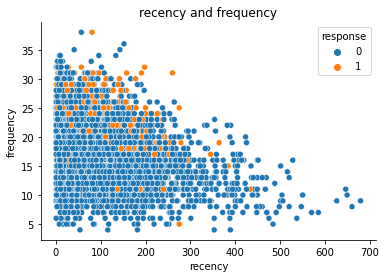

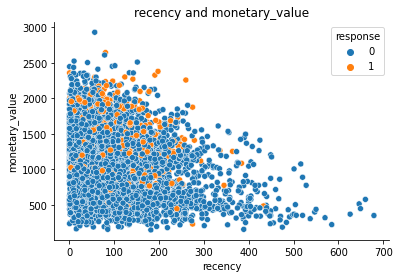

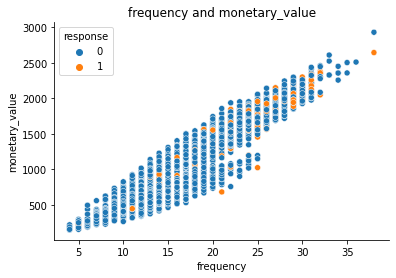

In [15]:
for i, col_i in enumerate(df_modeling[['recency', 'frequency', 'monetary_value']].columns):
  for j, col_j in enumerate(df_modeling[['recency', 'frequency', 'monetary_value']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

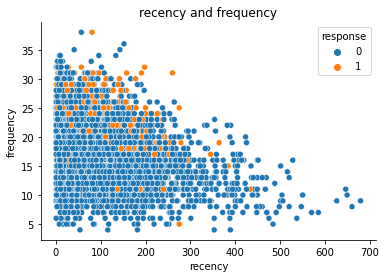

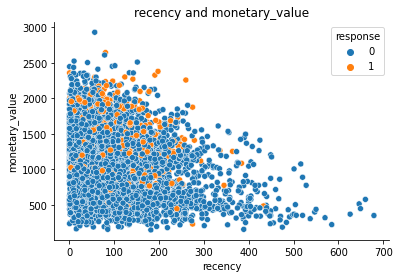

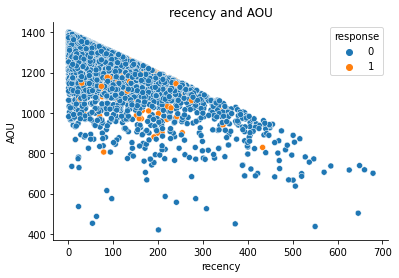

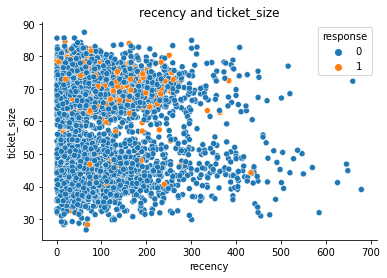

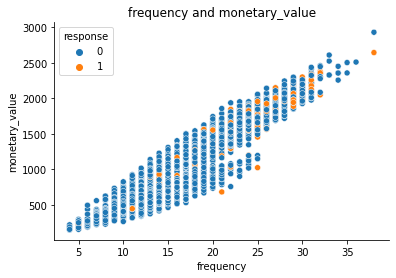

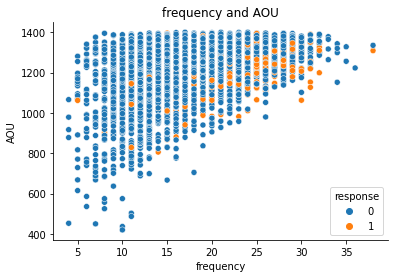

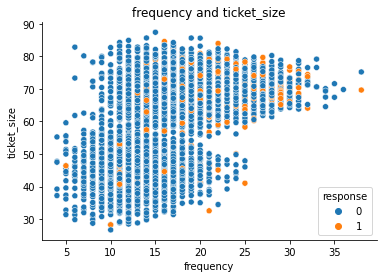

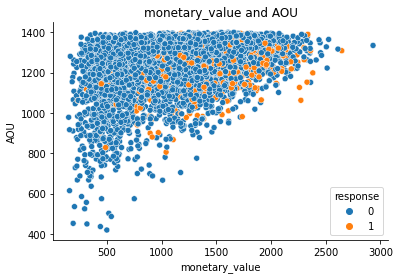

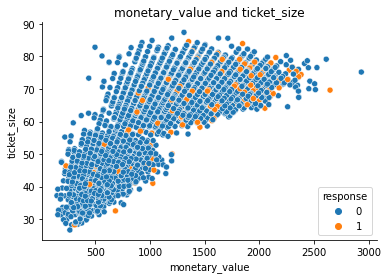

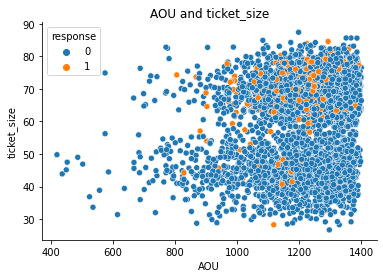

In [16]:
for i, col_i in enumerate(df_modeling[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
  for j, col_j in enumerate(df_modeling[['recency', 'frequency', 'monetary_value', 'AOU', 'ticket_size']].columns):
    if i < j :
      plt.title(col_i + ' and ' + col_j)
      sns.scatterplot(data=df_modeling, x=col_i, y=col_j, hue='response')
      sns.despine()
      plt.show()

# **Fixing imbalanced with SMOTE**

In [17]:
#Over Sampling
sm = SMOTE(random_state=0 ,k_neighbors=3)
sm.fit(X_train, y_train)
X_SMOTE, y_SMOTE = sm.fit_resample(X_train, y_train )
print(f'response before smote : {sum(y_train)} total data {len(y_train)}')
print(f'response after smote : {sum(y_SMOTE)} total data {len(y_SMOTE)}')

response before smote : 429 total data 4818
response after smote : 4389 total data 8778


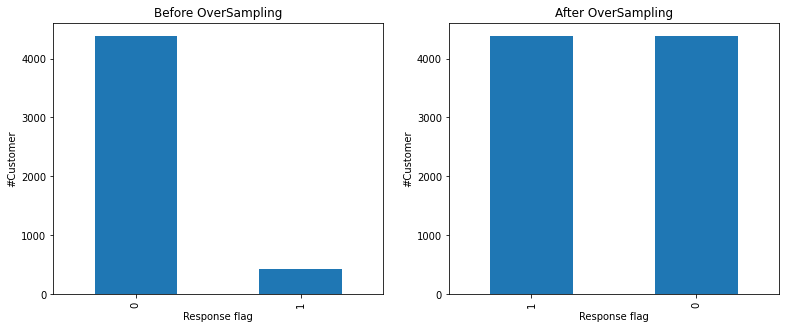

In [73]:
plt.figure(figsize=(13, 5))
plt.subplot(121)
y_train.value_counts().plot.bar()
plt.title('Before OverSampling')
plt.xlabel('Response flag')
plt.ylabel('#Customer')

plt.subplot(122)
y_SMOTE.value_counts().plot.bar()
plt.title('After OverSampling')
plt.xlabel('Response flag')
plt.ylabel('#Customer')
plt.show()

# **Logistic Regression**

In [77]:
print('logistic regression model - SMOTE RFM')
logreg = LogisticRegression(solver='liblinear', class_weight='balanced')
predicted_y = []
expected_y = []

logreg_model_SMOTE_rfm = logreg.fit(X_SMOTE, y_SMOTE)
predictions = logreg_model_SMOTE_rfm.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)
print('training set')
print(report_train) 

predicted_y = []
expected_y = []
predictions = logreg_model_SMOTE_rfm.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

logistic regression model - SMOTE RFM
training set
              precision    recall  f1-score   support

           0       0.68      0.66      0.67      4389
           1       0.67      0.69      0.68      4389

    accuracy                           0.67      8778
   macro avg       0.67      0.67      0.67      8778
weighted avg       0.67      0.67      0.67      8778

test set
              precision    recall  f1-score   support

           0       0.94      0.67      0.78      1848
           1       0.19      0.66      0.30       218

    accuracy                           0.67      2066
   macro avg       0.57      0.67      0.54      2066
weighted avg       0.86      0.67      0.73      2066



In [81]:
print('Logistic regression model - SMOTE RFM\n\n')

print('|> Training set')
auc_train = roc_auc_score(y_train, logreg_model_SMOTE_rfm.predict_proba(X_train)[:, 1])
print(report_train) 
print(f"AUC Train : {auc_train:.4f}\n\n")

print('|> test set')
auc_test =  roc_auc_score(y_test, logreg_model_SMOTE_rfm.predict_proba(X_test)[:, 1])
print(report_test) 
print(f"AUC Test  : {auc_test:.4f}")

Logistic regression model - SMOTE RFM


|> Training set
              precision    recall  f1-score   support

           0       0.68      0.66      0.67      4389
           1       0.67      0.69      0.68      4389

    accuracy                           0.67      8778
   macro avg       0.67      0.67      0.67      8778
weighted avg       0.67      0.67      0.67      8778

AUC Train : 0.7165


|> test set
              precision    recall  f1-score   support

           0       0.94      0.67      0.78      1848
           1       0.19      0.66      0.30       218

    accuracy                           0.67      2066
   macro avg       0.57      0.67      0.54      2066
weighted avg       0.86      0.67      0.73      2066

AUC Test  : 0.7130


# **XGBoost**

In [82]:
print('XGBoost model - SMOTE RFM')

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',
 learning_rate =0.01,
 n_estimators=100,
 max_depth=2,
 gamma=0.0,
 colsample_bytree=0.6)

predicted_y = []
expected_y = []

xgb_model_SMOTE = xgb_model.fit(X_SMOTE, y_SMOTE, early_stopping_rounds=10, eval_set=[(X_test, y_test)])
predictions =  xgb_model_SMOTE.predict(X_SMOTE)
predicted_y.extend(predictions)
expected_y.extend(y_SMOTE)
report_train = classification_report(expected_y, predicted_y)

predicted_y = []
expected_y = []
predictions = xgb_model_SMOTE.predict(X_test)
predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)


XGBoost model - SMOTE RFM
[0]	validation_0-auc:0.706109
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.706109
[2]	validation_0-auc:0.719116
[3]	validation_0-auc:0.718228
[4]	validation_0-auc:0.718565
[5]	validation_0-auc:0.715779
[6]	validation_0-auc:0.71245
[7]	validation_0-auc:0.718997
[8]	validation_0-auc:0.720439
[9]	validation_0-auc:0.719943
[10]	validation_0-auc:0.719761
[11]	validation_0-auc:0.720778
[12]	validation_0-auc:0.722617
[13]	validation_0-auc:0.722178
[14]	validation_0-auc:0.722352
[15]	validation_0-auc:0.723044
[16]	validation_0-auc:0.722487
[17]	validation_0-auc:0.723495
[18]	validation_0-auc:0.723803
[19]	validation_0-auc:0.724599
[20]	validation_0-auc:0.725689
[21]	validation_0-auc:0.725823
[22]	validation_0-auc:0.725399
[23]	validation_0-auc:0.725972
[24]	validation_0-auc:0.724026
[25]	validation_0-auc:0.72346
[26]	validation_0-auc:0.723207
[27]	validation_0-auc:0.728918
[28]	validation_0-auc:0.729673
[29]	validation_0-auc:0

In [83]:
print('XGBoost model - SMOTE RFM\n\n')

print('|> Training set')
auc_train = roc_auc_score(y_train, xgb_model_SMOTE.predict_proba(X_train)[:, 1])
print(report_train) 
print(f"AUC Train : {auc_train:.4f}\n\n")

print('|> test set')
auc_test =  roc_auc_score(y_test, xgb_model_SMOTE.predict_proba(X_test)[:, 1])
print(report_test) 
print(f"AUC Test  : {auc_test:.4f}")

XGBoost model - SMOTE RFM


|> Training set
              precision    recall  f1-score   support

           0       0.73      0.58      0.65      4389
           1       0.65      0.78      0.71      4389

    accuracy                           0.68      8778
   macro avg       0.69      0.68      0.68      8778
weighted avg       0.69      0.68      0.68      8778

AUC Train : 0.7455


|> test set
              precision    recall  f1-score   support

           0       0.96      0.58      0.73      1848
           1       0.18      0.79      0.30       218

    accuracy                           0.61      2066
   macro avg       0.57      0.69      0.51      2066
weighted avg       0.88      0.61      0.68      2066

AUC Test  : 0.7300


# hyper parameter tuning

In [27]:
## building pipeline for hyperparameter tuning

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2

# Create a pipeline
pipe = Pipeline([
  ('fs', SelectKBest()),
  ('clf', xgb.XGBClassifier(objective='binary:logistic', scale_pos_weight=9))
])

In [29]:
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
# Define our search space for grid search
search_space = [
  { 'clf__n_estimators': [100, 300],
    'clf__learning_rate': [0.01, 0.1],
    'clf__max_depth': range(2, 5),
    'clf__colsample_bytree': [i/10.0 for i in range(4, 7)],
    'clf__gamma': [i/10.0 for i in range(3)],
    'fs__score_func': [chi2],
    'fs__k': [2],
  }
]
# Define cross validation
kfold = KFold(n_splits=5)
# AUC and F1 as score
scoring = {'AUC':'roc_auc','F1 score': 'f1_micro'}
# Define grid search
grid = GridSearchCV(
  pipe,
  param_grid=search_space,
  cv=kfold,
  scoring=scoring,
  refit='AUC',
  verbose=1,
  n_jobs=-1
)

# Fit grid search
xgb_model_GS = grid.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [30]:
predicted_y = []
expected_y = []
predictions = xgb_model_GS.predict(X_test)
print('Best AUC Score: {}'.format(xgb_model_GS.best_score_))
print(confusion_matrix(y_test,predictions))


predicted_y.extend(predictions)
expected_y.extend(y_test)
report_test = classification_report(expected_y, predicted_y)
print('test set')
print(report_test) 

Best AUC Score: 0.7052982263787515
[[1180  668]
 [  66  152]]
test set
              precision    recall  f1-score   support

           0       0.95      0.64      0.76      1848
           1       0.19      0.70      0.29       218

    accuracy                           0.64      2066
   macro avg       0.57      0.67      0.53      2066
weighted avg       0.87      0.64      0.71      2066



# AUC Score

In [32]:
auc_train = roc_auc_score(y_train, xgb_model_GS.predict_proba(X_train)[:, 1])
auc_test =  roc_auc_score(y_test, xgb_model_GS.predict_proba(X_test)[:, 1])
print(f"AUC Train : {auc_train:.4f}")
print(f"AUC Test  : {auc_test:.4f}")

AUC Train : 0.7338
AUC Test  : 0.7058
